## Clasificación Binaria con Regresión Logística

### Entender el problema

Nos piden un modelo que prediga si los clientes van a pagar o impagar para poder hacer acciones preventivas en algún caso (clientes ya existentes) o comerciales (créditos preconcedidos). 

Parace muy claro, pero ¿qué significa impagar? ¿Es que mañana dejo de pagar una factura?¿Y si la repongo en menos de 30 días?¿Es tener una deuda a los seis meses sin pagar? Esto tenemos que aclararlo, no esperar a deducirlo del datatset (Aunque en estos ejemplos lo hagamos así). En nuestro caso nos contestan que es tener deudas pendientes de más de 2 años. Perfecto. Vamos con ello.

### Preparación Datos: Primer Vistazo

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pprint import pprint
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('data/cs-training.csv')

df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Preparación Datos: Limpieza de datos

In [2]:
df.rename(columns = {'SeriousDlqin2yrs': 'target'}, inplace=True)

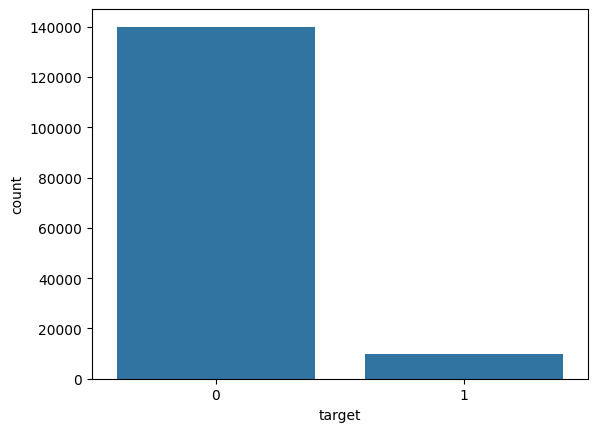

In [3]:
sns.countplot(data=df, x='target');

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   target                                150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [5]:
# Nos cargamos columnas inutiles
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
# Nos cargamos nulos
df.dropna(inplace=True)

### Preparación datos: Dividimos el dataset

In [7]:
from sklearn.model_selection import train_test_split 

X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42) 

### MiniEDA: Matriz de correlación
Vamos a cargarnos algunas columnas que no estén muy relacionadas con el target (seria más aconsejable descartarlo haciendo un bivariante con test de hipótesis o usando pairplot, aunque hay que tener en cuenta que debe hacerse por partes porque pairplot es muy demandante y este dataset es grande en dato).

In [8]:
df_eda = X_train.copy()
df_eda["target"] = y_train.copy()

In [9]:
np.abs(df_eda.corr()['target']).sort_values(ascending=False)

target                                  1.000000
NumberOfTime30-59DaysPastDueNotWorse    0.127577
NumberOfTimes90DaysLate                 0.115376
age                                     0.102266
NumberOfTime60-89DaysPastDueNotWorse    0.098259
NumberOfDependents                      0.046620
NumberOfOpenCreditLinesAndLoans         0.027646
MonthlyIncome                           0.018645
NumberRealEstateLoansOrLines            0.004433
DebtRatio                               0.003192
RevolvingUtilizationOfUnsecuredLines    0.002603
Name: target, dtype: float64

In [10]:
corr = np.abs(df_eda.corr()['target']).sort_values(ascending=False)

# Features con menos de 0.1 de correlación vs el target
bad_corr_feat = corr[corr < 0.05].index.values

# Filtramos las columnas buenas
df_eda.drop(columns=bad_corr_feat, inplace=True)

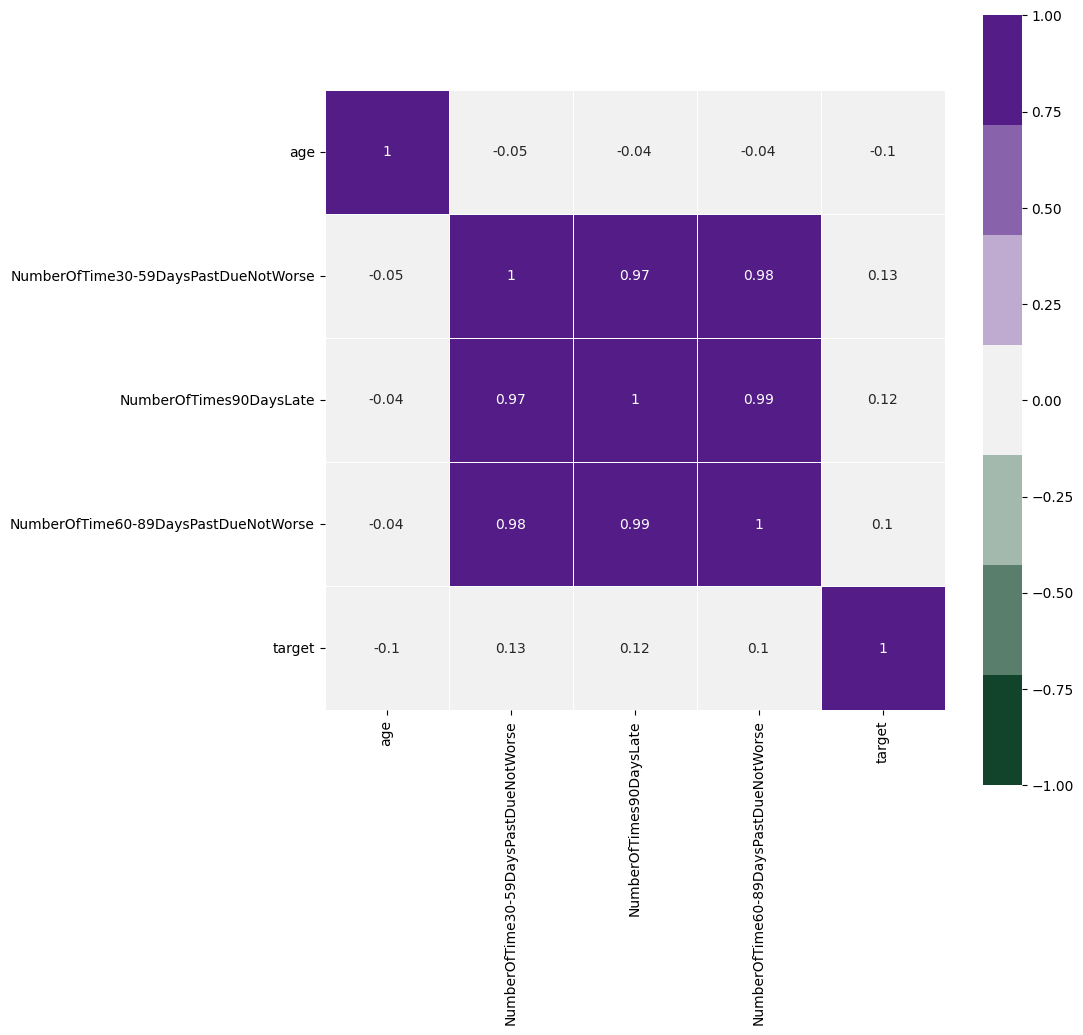

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df_eda.corr(), 2),
            vmin=-1,
            vmax=1,
            annot=True,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=7),
            square=True,
            linewidths=.5);

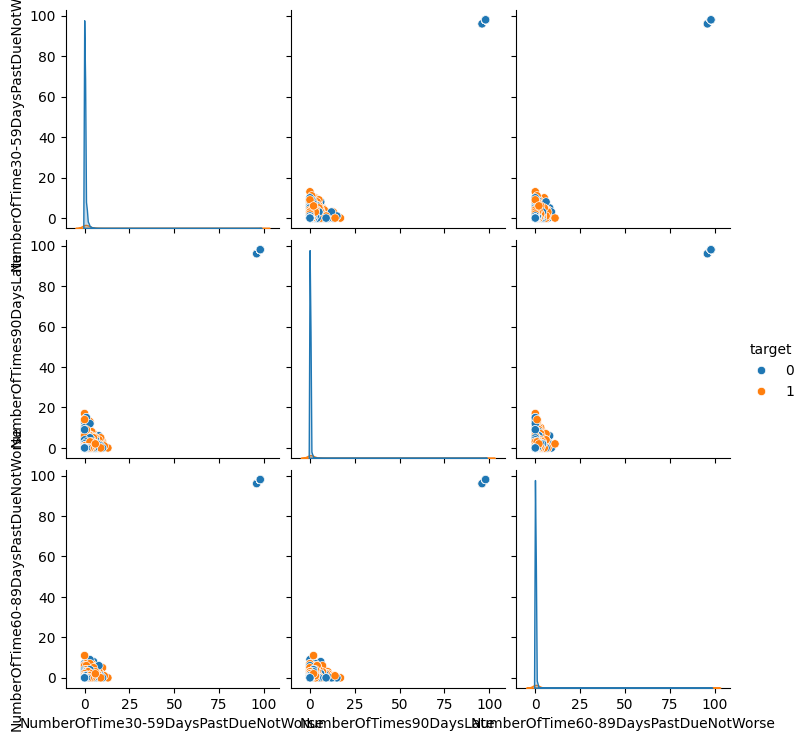

In [12]:
sns.pairplot(df_eda[[col for col in df_eda.columns if "NumberOf" in col or col == "target"]], hue = "target")

Te invito a usar nuestra librería de funciones gráficas para hacer un bivariante al estilo de las diagonales para las features con la mayor correlación.

In [13]:
features_num = [col for col in df_eda.columns if "target" not in col]
X_train = X_train[features_num].copy()

### Preparación de Features

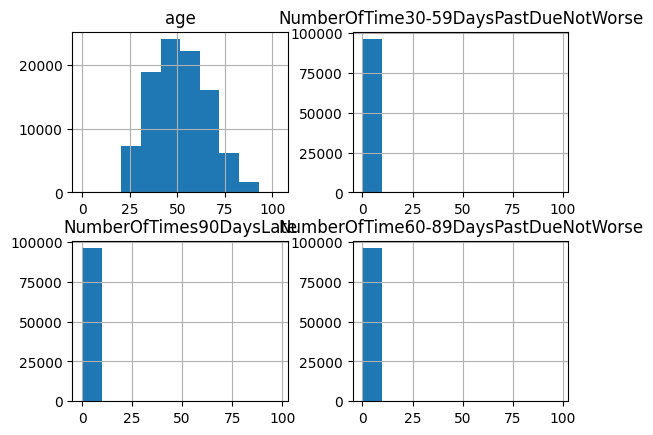

In [14]:
X_train.hist();

In [15]:
X_train.describe()

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
count,96215.000000,96215.000000,96215.000000,96215.000000
mean,51.285174,0.380211,0.210248,0.186676
std,14.428079,3.479168,3.444867,3.427351
min,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,0.000000,0.000000
50%,51.000000,0.000000,0.000000,0.000000
75%,61.000000,0.000000,0.000000,0.000000
max,103.000000,98.000000,98.000000,98.000000


In [16]:
X_train[X_train["NumberOfTime30-59DaysPastDueNotWorse"] > 0]

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse
44650,41,2,1,0
27331,39,1,0,0
85530,53,1,0,0
106214,45,3,0,0
106548,47,2,0,0
...,...,...,...,...
934,45,1,0,0
51349,30,3,0,0
55095,61,2,0,0
46514,78,1,0,0


Podríamos hacer categóricas de las "veces en días vencidos", pero lo vamos a dejar así por espacio, no son variables para escalar necesariamente.

### Modelo

In [17]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 5000)

log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

Veremos los hiperparámetros (en este caso argumentos al constructor de la clase LogisticRegression) a medida que vayamos usando el modelo. Ahora tratemos "max_iter":

`max_iter` = numero de iteraciones del optimizador (recuerda que el gradiente descendente va probando combinaciones hasta que encuentra una que no mejora la función de minimización después de varios intentos), esta es otra forma de decirle el máximo número de combinaciones, de veces que se aplica el gradiennte descendente en caso de que no se llegue a la condición anterior (denominada tolerancia)



In [18]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-0.02789161  0.50545547  0.43901075 -0.9050834 ]]
[-1.46237341]
[0 1]


### Feature importance

In [19]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
NumberOfTime60-89DaysPastDueNotWorse,0.905083
NumberOfTime30-59DaysPastDueNotWorse,0.505455
NumberOfTimes90DaysLate,0.439011
age,0.027892


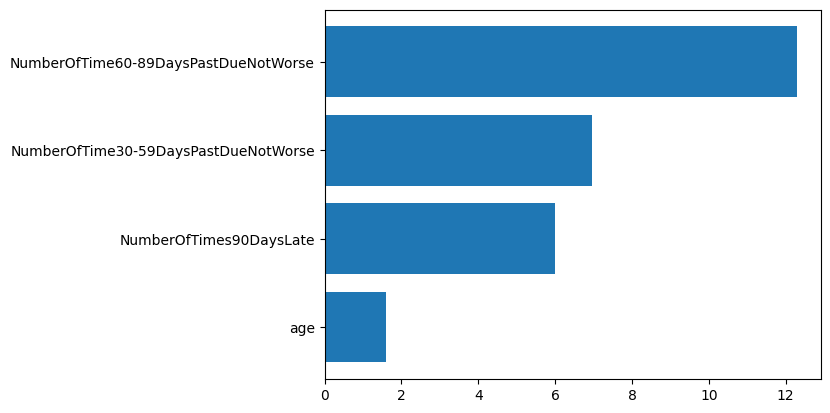

In [20]:
stdevs = []
for i in X_train.columns:
    stdev = df[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]
features['importance_standarized'] = features['importance'] / y_train.std()

features = features.sort_values('importance_standarized', ascending=True)
plt.barh(features.index, features.importance_standarized);

## Accuracy

Antes de usar el X_test hay que hacerles las mismas transformaciones que le hayamos hecho al X_train

In [21]:
X_test = X_test[X_train.columns].copy()

In [22]:
from sklearn.metrics import accuracy_score

acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.932
Accuracy test: 0.929


¿Es buenos nuestro clasificador?

In [23]:
y_train.value_counts(True)

target
0    0.93079
1    0.06921
Name: proportion, dtype: float64

In [24]:
y_test.value_counts(True)

target
0    0.929409
1    0.070591
Name: proportion, dtype: float64

No, no lo es. Tendríamos que tratarlo de alguna forma mejor (Está muy desbalanceado) o ver otras métricas

### Confusion matrix

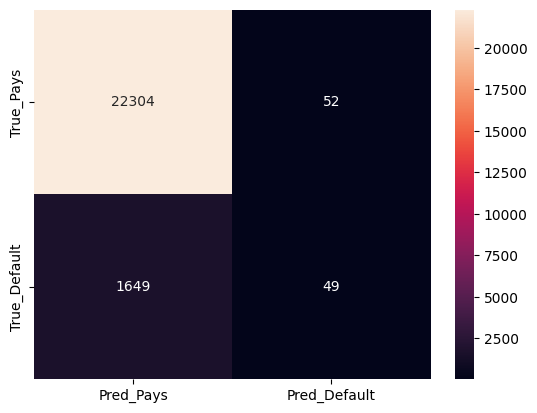

In [25]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, log_reg.predict(X_test))

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


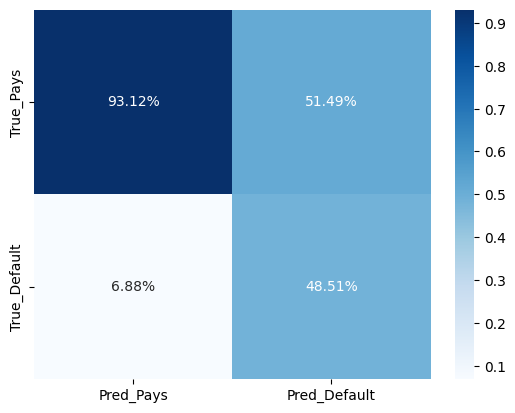

In [26]:
sns.heatmap(c_matrix_df/np.sum(c_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');

## Classification report

In [27]:
from sklearn.metrics import classification_report
from pprint import pprint

print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     22356
           1       0.49      0.03      0.05      1698

    accuracy                           0.93     24054
   macro avg       0.71      0.51      0.51     24054
weighted avg       0.90      0.93      0.90     24054



## ROC Curve

AUROC: 0.69


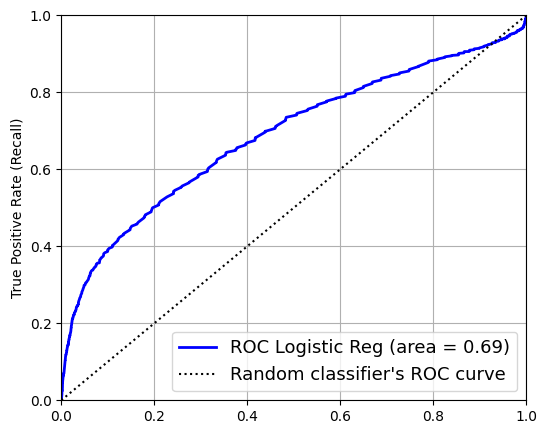

In [28]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

## Regresión Logística Multicategórica

### Entender el problema

Para mostrar la creación de un modelo multiclase y su evaluación vamos a tratar un problema en el que queremos detectar cuál es el sistema operativo de los usuarios que acceden a una dirección web específica (y que no es importante para el problema) en la que pasan un tiempo determinado, navegan a través de las páginas del site, realizan un conjunto de acciones y dejan una valoración de la misma. Encontrarás una variable "clase" que contiene el target, esta vez no tendrás que buscarlo, y que toma tres posibles valores en función del OS: Windows, Linux, Mac. 

Creemos ese modelo predictor a partir de una regresión logística.

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [30]:
df_os = pd.read_csv("data/usuarios_win_mac_lin.csv")

clases = {
    0: 'Windows',
    1: 'Linux',
    2: 'Mac'
}

df_os.head()

,duracion,paginas,acciones,valor,clase
0,7.0,2,4,8,2
1,21.0,2,6,6,2
2,57.0,2,4,4,2
3,101.0,3,6,12,2
4,109.0,2,6,12,2


Mostramos el target, y su balanceo o desbalanceo

In [31]:
df_os.clase.value_counts(True)

clase
0    0.505882
2    0.258824
1    0.235294
Name: proportion, dtype: float64

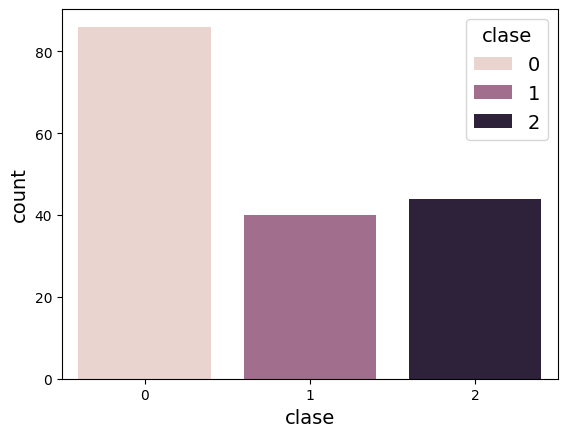

In [32]:
sns.countplot(x = "clase", data = df_os, hue = "clase");

Windows es el sistema dominante y habrá que tenerlo en cuenta a la hora de las medidas y tendríamos que tenerlo en cuenta a la hora de modelar pero lo veremos en sesiones posteriores.

Echamos un vistazo y sólo eso a la distribución de las variables contínuas (o sea casi todas) y nos fijamos en escala y figura

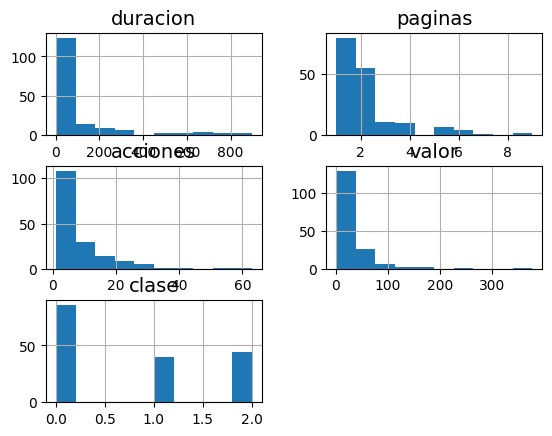

In [33]:
df_os.hist();

Tiene pinta de que vamos a tener que escalar y hacer alguna transformación para "normalizar" las distribuciones.

### Split

Son muy pocos datos (170) pero vamos a hacer el split igual para que vayamos cogiendo el hábito. Además estratificamos sobre el target (pero ojo esto es para hacer más limpio el ejercicio, por ejemplo porque suponemos que es algo que se va a mantener debido al marketshare de cada sistema operativo)

In [34]:
train_set, test_set = train_test_split(df_os, test_size= 0.2, stratify= df_os["clase"], random_state= 42)

In [35]:
train_set["clase"].value_counts(normalize = True)

clase
0    0.507353
2    0.257353
1    0.235294
Name: proportion, dtype: float64

In [36]:
test_set["clase"].value_counts(normalize = True)

clase
0    0.500000
2    0.264706
1    0.235294
Name: proportion, dtype: float64

### Mini-EDA

Vamos a ver la correlación de las variables con el target, pero realmente son tan pocas que no vamos a quitar ninguna:

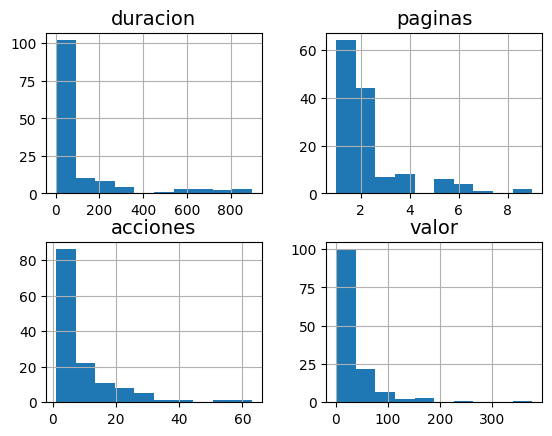

In [37]:
train_set.drop("clase", axis = 1).hist()
plt.show()

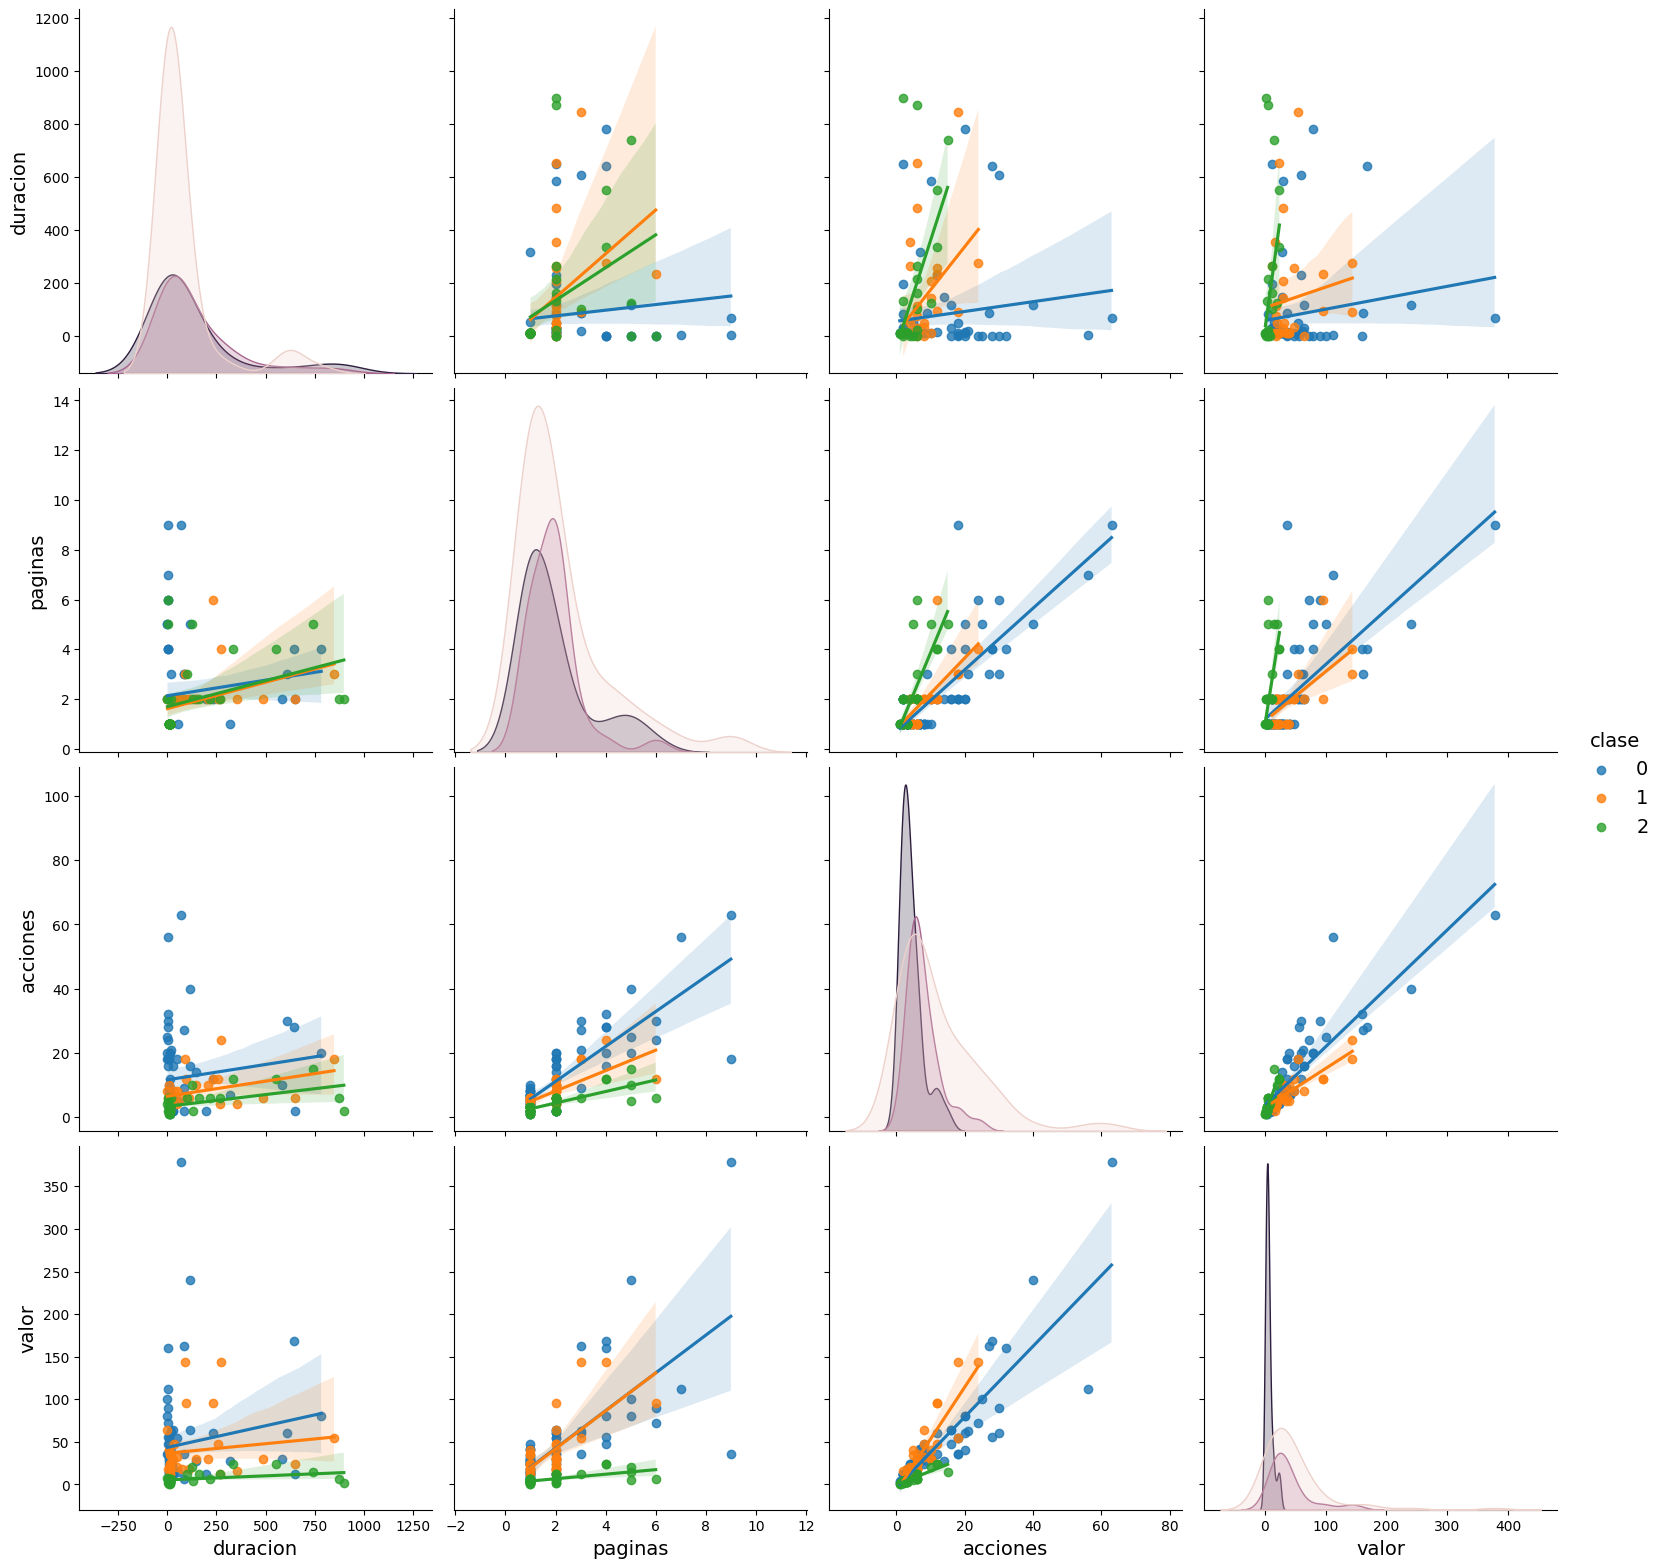

In [38]:
sns.pairplot(train_set,
            hue='clase',
            height=4,
            vars=["duracion", "paginas","acciones","valor"],
            kind='reg'); # "reg" de regresión lineal

In [39]:
features = train_set.drop("clase", axis = 1).columns.to_list()
print(features)

['duracion', 'paginas', 'acciones', 'valor']


### Procesamiento de Features

array([[<Axes: title={'center': 'duracion'}>,
        <Axes: title={'center': 'paginas'}>],
       [<Axes: title={'center': 'acciones'}>,
        <Axes: title={'center': 'valor'}>]], dtype=object)

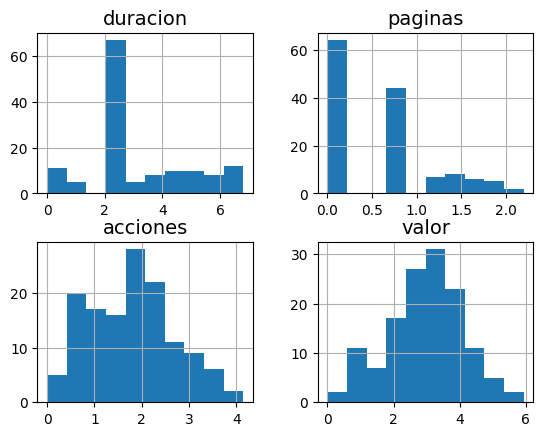

In [40]:
for col in features:
    train_set[col] = train_set[col].apply(np.log)
train_set[features].hist()

In [41]:
for col in features:
    test_set[col] = test_set[col].apply(np.log)
# Ojo ni lo mires :-), pero tienes que aplicarle las mismas transformaciones que el train.

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_set[features]) # Adaptamos el StandarScaler al Train, pero luego usamos el mismo en el test (porque ya la media y la desviación son las del train)
X_train = pd.DataFrame(scaler.transform(train_set[features]), columns = features)
X_test = pd.DataFrame(scaler.transform(test_set[features]), columns= features)
X_train.describe()

,duracion,paginas,acciones,valor
count,1.360000e+02,1.360000e+02,1.360000e+02,1.360000e+02
mean,-1.632681e-16,-4.571507e-17,2.416368e-16,-3.395976e-16
std,1.003697e+00,1.003697e+00,1.003697e+00,1.003697e+00
min,-1.878357e+00,-8.947527e-01,-2.004312e+00,-2.501146e+00
25%,-4.781410e-01,-8.947527e-01,-7.831545e-01,-7.258228e-01
50%,-3.805922e-01,2.695613e-01,-1.268982e-02,2.121177e-01
75%,7.491348e-01,2.695613e-01,7.577748e-01,6.482352e-01
max,2.092503e+00,2.796035e+00,2.600971e+00,2.565771e+00


In [43]:
y_train = train_set["clase"]
y_test = test_set["clase"]

### Creamos el modelo

In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=10000) 

clf.fit(X_train, y_train) # No hay que decir nada en especial, el detecta el tipo de clasificador multicategórico y aplica el one-vs-rest o one-vs-all

LogisticRegression(max_iter=10000)

Si mostramos los coeficientes o pesos del modelo veremos que en realidad ha entrenado un modelo de regresión logística para cada clase como vimos en la sesión de teoría. Ha hecho un one-vs-rest

In [45]:
clf.coef_

array([[-0.33875784, -0.28243018, -0.11998396,  1.06520743],
       [ 0.20873356, -0.2993436 , -0.96504166,  1.8810649 ],
       [ 0.13002428,  0.58177378,  1.08502562, -2.94627234]])

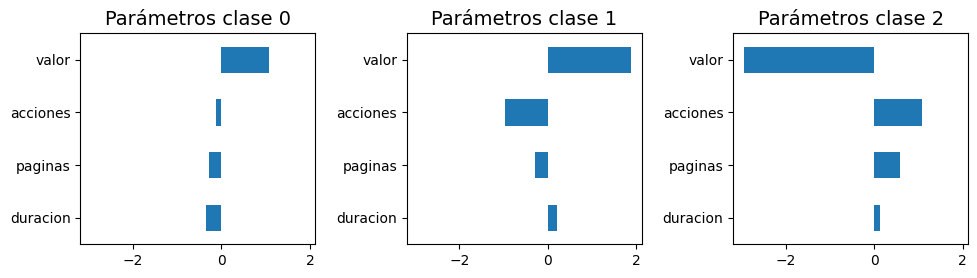

In [46]:
df_coefs = pd.DataFrame(clf.coef_, columns=X_train.columns)

fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
for i, subdf in df_coefs.iterrows():
    subdf.plot(kind="barh", ax=ax[i])
    ax[i].set_title(f"Parámetros clase {i}")

fig.tight_layout()

Ten en cuenta que estos coeficientes están aplicados sobre el logaritmo de las variables, aún así puedes ver que influye en la selección de cada clase.

Podemos ver las predicciones

In [47]:
clf.predict(X_train)

array([0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 2, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2,
       2, 0, 2, 0], dtype=int64)

Y las probabilidades para cada instancia, nos da un vector de tres probabilidades una para cada clase y puedes comprobar que escoge la de mayor probabilidad:

In [48]:
clf.predict_proba(X_train)

array([[0.71646107, 0.27437523, 0.0091637 ],
       [0.39537849, 0.10494105, 0.49968046],
       [0.62557227, 0.33522879, 0.03919894],
       [0.67445683, 0.3220793 , 0.00346387],
       [0.19058325, 0.1395637 , 0.66985306],
       [0.38953368, 0.10630614, 0.50416017],
       [0.53891527, 0.45985535, 0.00122939],
       [0.7588464 , 0.2158235 , 0.0253301 ],
       [0.4699667 , 0.05470718, 0.47532612],
       [0.5911302 , 0.24190819, 0.16696161],
       [0.68803294, 0.30935528, 0.00261178],
       [0.70699895, 0.28786924, 0.00513181],
       [0.7488766 , 0.21916641, 0.03195698],
       [0.71317964, 0.2665672 , 0.02025316],
       [0.8085818 , 0.1752283 , 0.0161899 ],
       [0.70441951, 0.21905707, 0.07652343],
       [0.60960877, 0.38184107, 0.00855016],
       [0.5761585 , 0.38260778, 0.04123372],
       [0.8861692 , 0.06840359, 0.04542722],
       [0.59449295, 0.3296183 , 0.07588875],
       [0.4812114 , 0.49446707, 0.02432153],
       [0.33802073, 0.52311691, 0.13886235],
       [0.

In [49]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, clf.predict(X_train))
print(acc_train)

0.7279411764705882


## Clasificación Multicategórica con Regresión Logística

### Validamos el modelo

Usemos la validación cruzada no tanto para comparar con otros modelos, que no tenemos, sino como para adelantarnos a la evaluación con el test y de nuevo ir cogiendo hábito.

In [50]:
from sklearn import model_selection
name='Logistic Regression'
cv_results = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(cv_results)
print(msg)

[0.64285714 0.62962963 0.66666667 0.66666667 0.77777778]
Logistic Regression: 0.676720 (0.052496)


Ya vemos que sale menor que el 72% del train. 

### Evaluación del modelo  



In [51]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

In [52]:
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

#### Matriz de confusion

A mano, como un dataframe a partir de los datos que nos da el `confusion_matrix` de sklearn:

In [53]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[f"Real {i}" for i in clf.classes_], 
                  columns=[f"Predicho {i}" for i in clf.classes_])

cm

,Predicho 0,Predicho 1,Predicho 2
Real 0,14,0,3
Real 1,3,5,0
Real 2,0,0,9


Gráficamente:

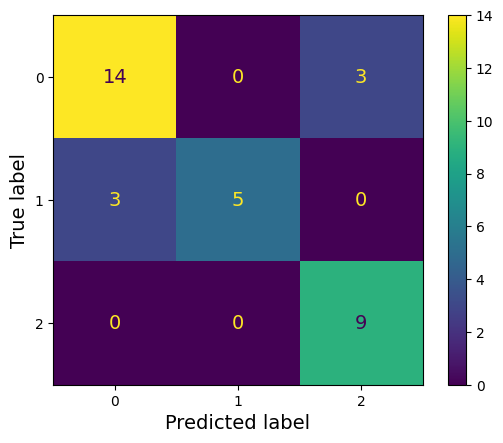

In [54]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


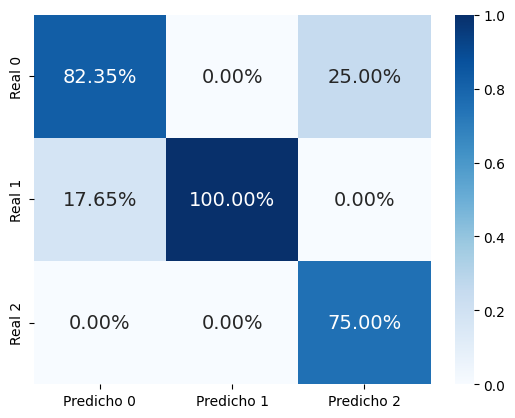

In [55]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues');

### Métricas MACRO y MICRO

In [56]:


micro_prec = precision_score(y_test, y_pred, average="micro")
print("MICRO PRECISION:", micro_prec)

macro_prec = precision_score(y_test, y_pred, average="macro")
print("MACRO PRECISION:", macro_prec)

micro_rec = recall_score(y_test, y_pred, average="micro")
print("MICRO RECALL:", micro_rec)

macro_rec = recall_score(y_test, y_pred, average="macro")
print("MACRO RECALL:", macro_rec)

micro_acc = accuracy_score(y_test, y_pred)
print("MICRO ACCURACY:", micro_acc)

MICRO PRECISION: 0.8235294117647058
MACRO PRECISION: 0.8578431372549019
MICRO RECALL: 0.8235294117647058
MACRO RECALL: 0.8161764705882352
MICRO ACCURACY: 0.8235294117647058


In [57]:
acierto = accuracy_score(y_test, y_pred)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 82.35 %
Error: 17.65 %


#### Informe de Resultados

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        17
           1       1.00      0.62      0.77         8
           2       0.75      1.00      0.86         9

    accuracy                           0.82        34
   macro avg       0.86      0.82      0.82        34
weighted avg       0.85      0.82      0.82        34



#### Clasificación de nuevos registros

Para terminar veamos como sería la predicción para un usuario que dedica una duración de 1, ve 1 página, ejecuta 1 acción y valora con 2 el site

In [59]:
new_data = pd.DataFrame(scaler.transform(np.log(np.array([[1, 1, 1, 2]]))),columns = features)
print(new_data)
print(clf.predict_proba(new_data))
print(clf.predict(new_data))

   duracion   paginas  acciones     valor
0 -1.878357 -0.894753 -2.004312 -1.909372
[[0.1308694  0.02107045 0.84806015]]
[2]


c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
